In [1]:
# import packages
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score
import datetime as dt
from sklearn import linear_model
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from scipy import stats

# suppress warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Traffic Modeling for Real-Time Autonomous Vehicle Solutions in LGA

Instructor: Dr.Stanislav Sobolevsky

Objectives:
* Find possible correlations from observations
* Incorporate time patterns using dummy variables
* Run and diagnose linear models, in-sample and out-of-sample. Perform feature selection
* Cluster the days based on their ridership patterns to see if we can detect any outliers

In [2]:
# import and curate the dataset
TaxiRidership = pd.read_csv("/home/jovyan/shared/Data/LGAVehicleByHour.csv")
FlightArrival = pd.read_csv("/home/jovyan/shared/Data/LGAFlightArrival.csv")

In [3]:
TaxiRidership.head()

,DOLocationID,Date,vehicle_count
0,1,2018-01-01 00:00,0.0
1,2,2018-01-01 00:00,0.0
2,3,2018-01-01 00:00,0.0
3,4,2018-01-01 00:00,0.0
4,5,2018-01-01 00:00,0.0


In [4]:
FlightArrival.head()

,Date,arrivals
0,18/1/1 0:00,3
1,18/1/1 1:00,0
2,18/1/1 2:00,1
3,18/1/1 3:00,0
4,18/1/1 4:00,0


In [5]:
TaxiRidership.Date = pd.to_datetime(TaxiRidership.Date)
FlightArrival.Date = pd.to_datetime(FlightArrival.Date, format='%y/%m/%d %H:%M')

In [6]:
#get day of the week; monday - 0, sunday - 6
TaxiRidership['DOW']=pd.DatetimeIndex(TaxiRidership.Date).weekday

In [7]:
#get day from beginning of the year, hour and day of the week from datetime
TaxiRidership['Hour']=pd.DatetimeIndex(TaxiRidership.Date).hour

In [8]:
#get day from beginning of the year
TaxiRidership['day']=((TaxiRidership.Date-dt.datetime(2018,1,1))/dt.timedelta(days = 1)).astype(int)

## Spatial visualization

In [9]:
#load taxi zone shapefile from course shared data folder
#260 location_id's, but TaxiRidership only recorded 257 DOLocationID
#meaning merge step will create duplicates
taxi = gpd.read_file("/home/jovyan/shared/Data/taxizone.geojson")
taxi['location_id'] = taxi['location_id'].astype(str).astype(int)

#create an index column to help with dropping duplicated records after merging
TaxiRidership['index_col']=TaxiRidership.index

#merge taxi zone with ridership
tr_merge = taxi.merge(TaxiRidership, left_on='location_id', right_on='DOLocationID')

#drop duplicates 
tr_merge = tr_merge.drop_duplicates('index_col')

In [10]:
#create dataframes for each day 
#monday
tr_mon = tr_merge.loc[tr_merge['DOW']==0]
tr_0 = tr_mon.groupby(['location_id'], as_index=False).agg({'vehicle_count':'sum'})
tr_0['ind_'] = tr_0.index
tr_0_g = taxi.merge(tr_0, left_on='location_id', right_on='location_id')
tr_0_g= tr_0_g.drop_duplicates('ind_')

#tuesday
tr_tue = tr_merge.loc[tr_merge['DOW']==1]
tr_1 = tr_tue.groupby(['location_id'], as_index=False).agg({'vehicle_count':'sum'})
tr_1['ind_'] = tr_1.index
tr_1_g = taxi.merge(tr_1, left_on='location_id', right_on='location_id')
tr_1_g= tr_1_g.drop_duplicates('ind_')

#wednesday
tr_wed = tr_merge.loc[tr_merge['DOW']==2]
tr_2 = tr_wed.groupby(['location_id'], as_index=False).agg({'vehicle_count':'sum'})
tr_2['ind_'] = tr_2.index
tr_2_g = taxi.merge(tr_2, left_on='location_id', right_on='location_id')
tr_2_g= tr_2_g.drop_duplicates('ind_')

#thursday
tr_thu = tr_merge.loc[tr_merge['DOW']==3]
tr_3 = tr_thu.groupby(['location_id'], as_index=False).agg({'vehicle_count':'sum'})
tr_3['ind_'] = tr_3.index
tr_3_g = taxi.merge(tr_3, left_on='location_id', right_on='location_id')
tr_3_g= tr_3_g.drop_duplicates('ind_')

#friday
tr_fri = tr_merge.loc[tr_merge['DOW']==4]
tr_4 = tr_fri.groupby(['location_id'], as_index=False).agg({'vehicle_count':'sum'})
tr_4['ind_'] = tr_4.index
tr_4_g = taxi.merge(tr_4, left_on='location_id', right_on='location_id')
tr_4_g= tr_4_g.drop_duplicates('ind_')

#saturday
tr_sat = tr_merge.loc[tr_merge['DOW']==5]
tr_5 = tr_sat.groupby(['location_id'], as_index=False).agg({'vehicle_count':'sum'})
tr_5['ind_'] = tr_5.index
tr_5_g = taxi.merge(tr_5, left_on='location_id', right_on='location_id')
tr_5_g= tr_5_g.drop_duplicates('ind_')

#sunday
tr_sun = tr_merge.loc[tr_merge['DOW']==6]
tr_6 = tr_sun.groupby(['location_id'], as_index=False).agg({'vehicle_count':'sum'})
tr_6['ind_'] = tr_6.index
tr_6_g = taxi.merge(tr_6, left_on='location_id', right_on='location_id')
tr_6_g= tr_6_g.drop_duplicates('ind_')

Text(0.5, 1.0, 'Ridership from LGA, Mondays')

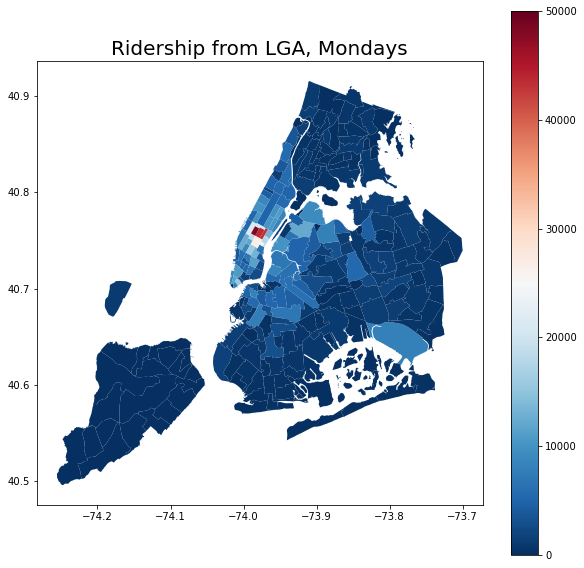

In [11]:
fig,ax = plt.subplots(figsize=(10,10))

#set vmin and vmax values so that all 7 graphs have the same colormap scale
#monday
tr_0_g.plot(ax=ax, column='vehicle_count', colormap='RdBu_r', legend=True, vmin=0, vmax=50000)
ax.set_title("Ridership from LGA, Mondays", fontsize=20)

Text(0.5, 1.0, 'Ridership from LGA, Tuesdays')

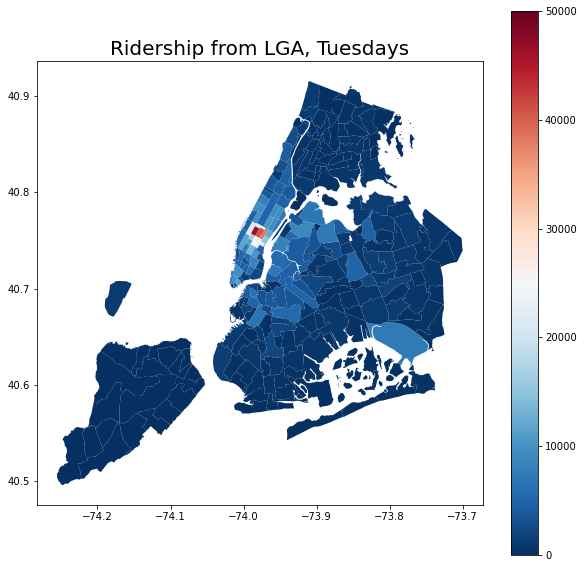

In [12]:
fig,ax = plt.subplots(figsize=(10,10))

#tuesday
tr_1_g.plot(ax=ax, column='vehicle_count', colormap='RdBu_r', legend=True, vmin=0, vmax=50000)
ax.set_title("Ridership from LGA, Tuesdays", fontsize=20)

Text(0.5, 1.0, 'Ridership from LGA, Wednesdays')

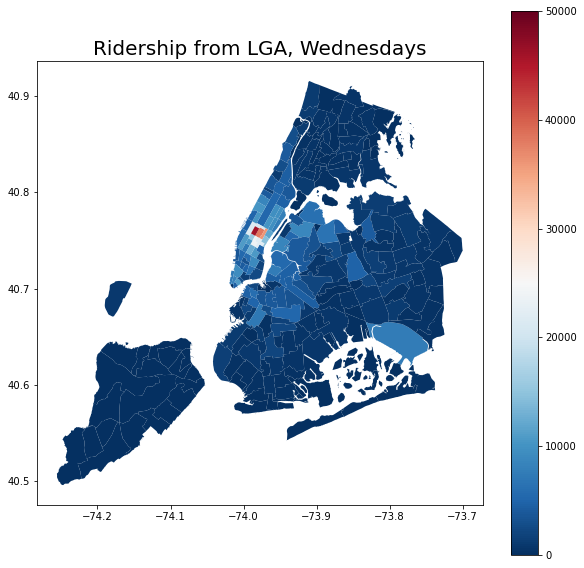

In [13]:
fig,ax = plt.subplots(figsize=(10,10))

#wednesday
tr_2_g.plot(ax=ax, column='vehicle_count', colormap='RdBu_r', legend=True, vmin=0, vmax=50000)
ax.set_title("Ridership from LGA, Wednesdays", fontsize=20)

Text(0.5, 1.0, 'Ridership from LGA, Thursdays')

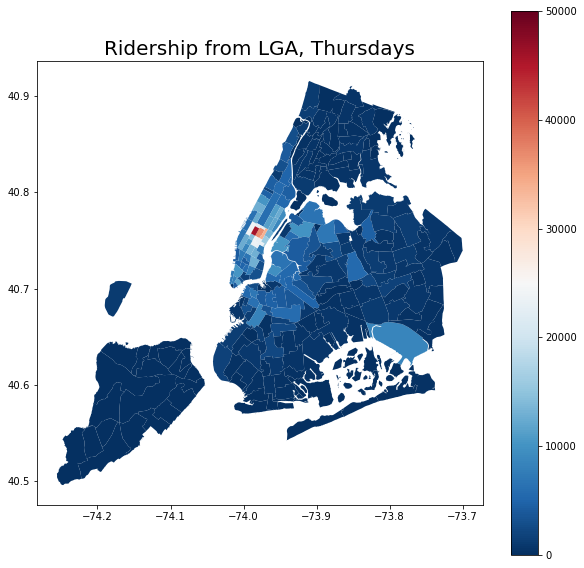

In [14]:
fig,ax = plt.subplots(figsize=(10,10))

#thursday
tr_3_g.plot(ax=ax, column='vehicle_count', colormap='RdBu_r', legend=True, vmin=0, vmax=50000)
ax.set_title("Ridership from LGA, Thursdays", fontsize=20)

Text(0.5, 1.0, 'Ridership from LGA, Fridays')

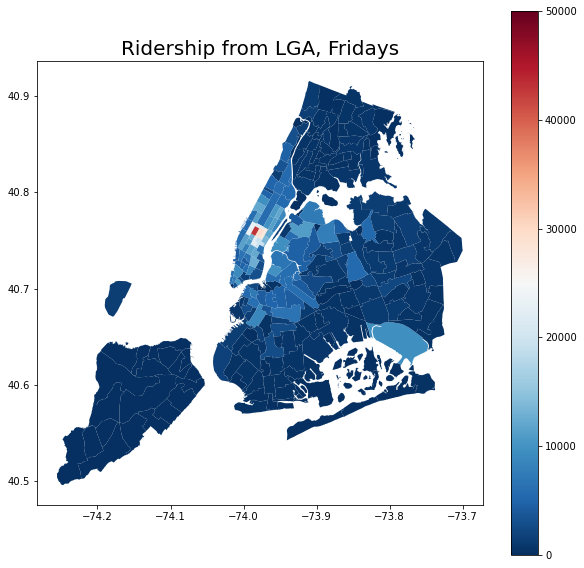

In [15]:
fig,ax = plt.subplots(figsize=(10,10))

#friday
tr_4_g.plot(ax=ax, column='vehicle_count', colormap='RdBu_r', legend=True, vmin=0, vmax=50000)
ax.set_title("Ridership from LGA, Fridays", fontsize=20)

Text(0.5, 1.0, 'Ridership from LGA, Saturdays')

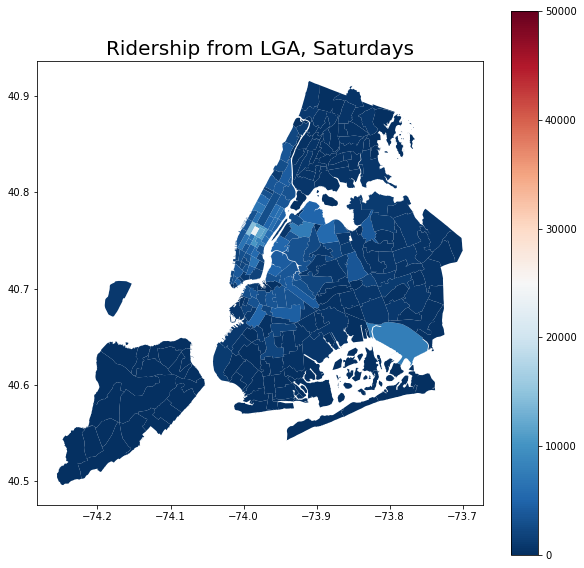

In [16]:
fig,ax = plt.subplots(figsize=(10,10))

#saturday
tr_5_g.plot(ax=ax, column='vehicle_count', colormap='RdBu_r', legend=True, vmin=0, vmax=50000)
ax.set_title("Ridership from LGA, Saturdays", fontsize=20)

Text(0.5, 1.0, 'Ridership from LGA, Sundays')

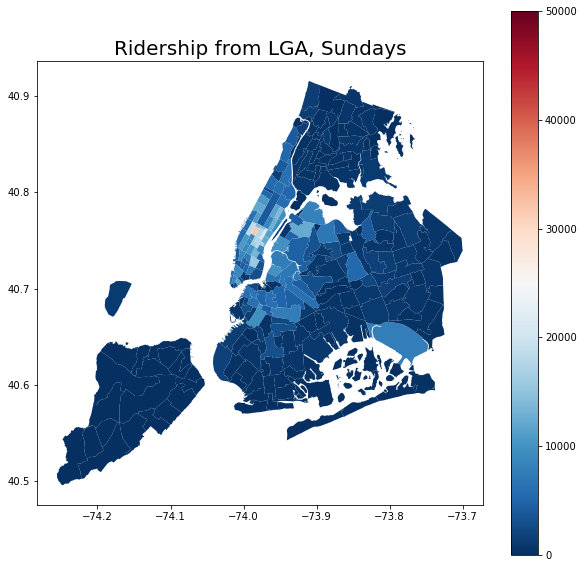

In [17]:
fig,ax = plt.subplots(figsize=(10,10))

#sunday
tr_6_g.plot(ax=ax, column='vehicle_count', colormap='RdBu_r', legend=True, vmin=0, vmax=50000)
ax.set_title("Ridership from LGA, Sundays", fontsize=20)

## Data preprocessing

In [18]:
#aggregate taxi ridership by Date-Hour for the whole city
tr_ = TaxiRidership.groupby(['Date'], as_index=False).agg({'vehicle_count':'sum'})

#merge aggregated taxi ridership and flight arrival
tr_f = FlightArrival.merge(tr_, left_on='Date', right_on='Date')

#create copy, just in case
import copy
tr_fa = copy.deepcopy(tr_f)
tr_fa = tr_fa[['Date', 'vehicle_count', 'arrivals']]
tr_fa

,Date,vehicle_count,arrivals
0,2018-01-01 00:00:00,142.0,3
1,2018-01-01 01:00:00,23.0,0
2,2018-01-01 02:00:00,2.0,1
3,2018-01-01 03:00:00,1.0,0
4,2018-01-01 04:00:00,13.0,0
...,...,...,...
8755,2018-12-31 19:00:00,467.0,11
8756,2018-12-31 20:00:00,599.0,13
8757,2018-12-31 21:00:00,384.0,8
8758,2018-12-31 22:00:00,410.0,8


In [1]:
#add time-lagged arrivals (1,2,3,4,5,6..12 hours before)

In [19]:
#create lag columns as hinted in the prompt
tr_fa['lag1'] = tr_fa['arrivals'].shift(1)
tr_fa['lag2'] = tr_fa['arrivals'].shift(2)
tr_fa['lag3'] = tr_fa['arrivals'].shift(3)
tr_fa['lag4'] = tr_fa['arrivals'].shift(4)
tr_fa['lag5'] = tr_fa['arrivals'].shift(5)
tr_fa['lag6'] = tr_fa['arrivals'].shift(6)
tr_fa['lag7'] = tr_fa['arrivals'].shift(7)
tr_fa['lag8'] = tr_fa['arrivals'].shift(8)
tr_fa['lag9'] = tr_fa['arrivals'].shift(9)
tr_fa['lag10'] = tr_fa['arrivals'].shift(10)
tr_fa['lag11'] = tr_fa['arrivals'].shift(11)
tr_fa['lag12'] = tr_fa['arrivals'].shift(12)

#print and check
tr_fa

,Date,vehicle_count,arrivals,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12
0,2018-01-01 00:00:00,142.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 01:00:00,23.0,0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 02:00:00,2.0,1,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 03:00:00,1.0,0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 04:00:00,13.0,0,0.0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-12-31 19:00:00,467.0,11,12.0,21.0,20.0,17.0,21.0,27.0,17.0,11.0,28.0,23.0,22.0,11.0
8756,2018-12-31 20:00:00,599.0,13,11.0,12.0,21.0,20.0,17.0,21.0,27.0,17.0,11.0,28.0,23.0,22.0
8757,2018-12-31 21:00:00,384.0,8,13.0,11.0,12.0,21.0,20.0,17.0,21.0,27.0,17.0,11.0,28.0,23.0
8758,2018-12-31 22:00:00,410.0,8,8.0,13.0,11.0,12.0,21.0,20.0,17.0,21.0,27.0,17.0,11.0,28.0


## Exploratory Analysis

In [20]:
#number of records for taxi ridership
print("The number of records for taxi ridership is : {0}".format(len(TaxiRidership)))

#number of hours for arrivals
print("The number of hours recorded for arrival is : {0}".format(len(FlightArrival)))

#number of total taxi & FHV trips
print("The total number of taxi and FHV trips is : {0}".format(TaxiRidership['vehicle_count'].sum()))

#number of total arrivals 
print("The total number of arrivals is : {0}".format(FlightArrival['arrivals'].sum()))

The number of records for taxi ridership is : 2251320
The number of hours recorded for arrival is : 8760
The total number of taxi and FHV trips is : 5430922.0
The total number of arrivals is : 163713


### Perform statistical analysis

In [21]:
#add DOW column to dataframe created in the previous task
tr_fa['DOW']=pd.DatetimeIndex(tr_fa.Date).weekday

#create dataframes for weekdays and weekends
taxi_wd = tr_fa.loc[(tr_fa['DOW'] >= 0) & (tr_fa['DOW'] <= 4)]
taxi_wk = tr_fa.loc[(tr_fa['DOW'] == 5) | (tr_fa['DOW'] == 6)]
taxi_weekdays=copy.deepcopy(taxi_wd)
taxi_weekends=copy.deepcopy(taxi_wk)

Text(0, 0.5, 'Probability Density')

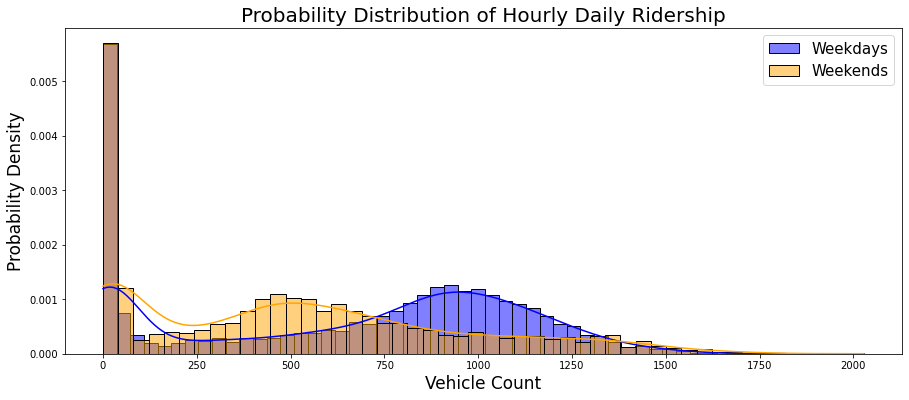

In [22]:
#plot the probability distribution in seaborn
import seaborn as sns
fig,ax = plt.subplots(figsize=(15,6))

sns.histplot(taxi_weekdays['vehicle_count'], bins=50,kde=True, stat='density', label='Weekdays', color='blue')
sns.histplot(taxi_weekends['vehicle_count'], bins=50,kde=True, stat='density', label='Weekends', color='orange')
ax.legend(fontsize=15, loc='best')
ax.set_title('Probability Distribution of Hourly Daily Ridership', fontsize=20)
ax.set_xlabel('Vehicle Count', fontsize=17)
ax.set_ylabel('Probability Density', fontsize=17)

Text(0, 0.5, 'Probability Density')

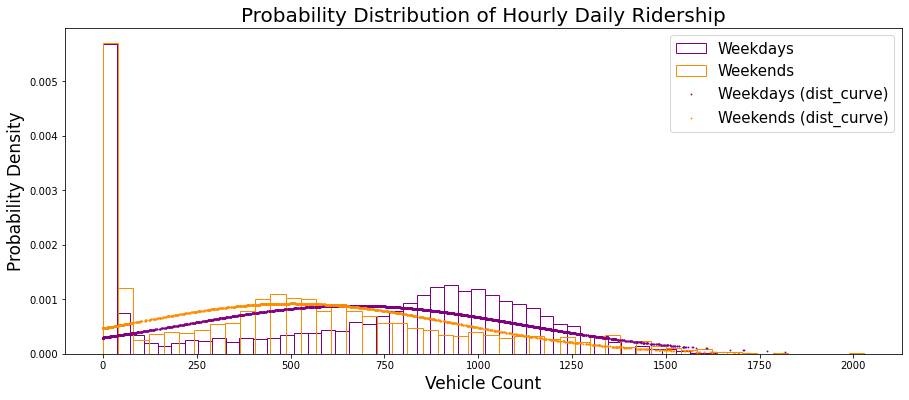

In [23]:
#alternatively, calculate norm.pdf as suggest in the prompt and plot in matplotlib
fig,ax = plt.subplots(figsize=(15,6))

taxi_weekdays['pdf'] = stats.norm.pdf(taxi_weekdays['vehicle_count'], loc=taxi_weekdays['vehicle_count'].mean(), scale=taxi_weekdays['vehicle_count'].std())
taxi_weekends['pdf'] = stats.norm.pdf(taxi_weekends['vehicle_count'], loc=taxi_weekends['vehicle_count'].mean(), scale=taxi_weekends['vehicle_count'].std())

ax.hist(taxi_weekdays['vehicle_count'], bins=50, density=True, facecolor='None', edgecolor='purple',label='Weekdays')
ax.scatter(taxi_weekdays['vehicle_count'],taxi_weekdays['pdf'], color='purple',s=0.7, label='Weekdays (dist_curve)', zorder=2)
ax.hist(taxi_weekends['vehicle_count'], bins=50, density=True, facecolor='None', edgecolor='darkorange',label='Weekends')
ax.scatter(taxi_weekends['vehicle_count'],taxi_weekends['pdf'], s=0.7, color='darkorange', label='Weekends (dist_curve)', zorder=2)

ax.legend(fontsize=15, loc='best')
ax.set_title('Probability Distribution of Hourly Daily Ridership', fontsize=20)
ax.set_xlabel('Vehicle Count', fontsize=17)
ax.set_ylabel('Probability Density', fontsize=17)

In [24]:
ti = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
task3_2_t_result = pd.DataFrame(index=ti, columns=['T-test Result (alpha = 0.05)'])
for a in range(7):
    row=[]
    t_test = stats.ttest_ind(tr_fa.loc[tr_fa['DOW']==a]['vehicle_count'], tr_fa.loc[tr_fa['DOW']!=a]['vehicle_count'])
    if t_test.pvalue < 0.05:
        row.append('True')
    else:
        row.append('False')
    task3_2_t_result.loc[ti[a]] = row
task3_2_t_result

,T-test Result (alpha = 0.05)
Monday,True
Tuesday,False
Wednesday,False
Thursday,True
Friday,True
Saturday,True
Sunday,False


### Timeseries Analysis

In [25]:
#add month column
tr_fa['Month'] = tr_fa['Date'].dt.month

#group by month
taxi_month = tr_fa.groupby('Month', as_index=False).aggregate({'vehicle_count':'sum'})

#find month with highest taxi ridership
print("The month with the highest total ridership is : {0}".format(np.argmax(taxi_month.vehicle_count)+1)) 

The month with the highest total ridership is : 10


In [26]:
#select only data from october
hm_tr = tr_fa.loc[tr_fa['Month']==10]
hm_tr_fa = copy.deepcopy(hm_tr)

#standardize ridership data
hm_tr_fa['vehicle_count_st'] = (hm_tr_fa['vehicle_count'] - hm_tr_fa['vehicle_count'].mean())/(hm_tr_fa['vehicle_count'].std())

#standardize arrivals data
hm_tr_fa['arrivals_st'] = (hm_tr_fa['arrivals'] - hm_tr_fa['arrivals'].mean())/(hm_tr_fa['arrivals'].std())

Text(0, 0.5, 'Standardized')

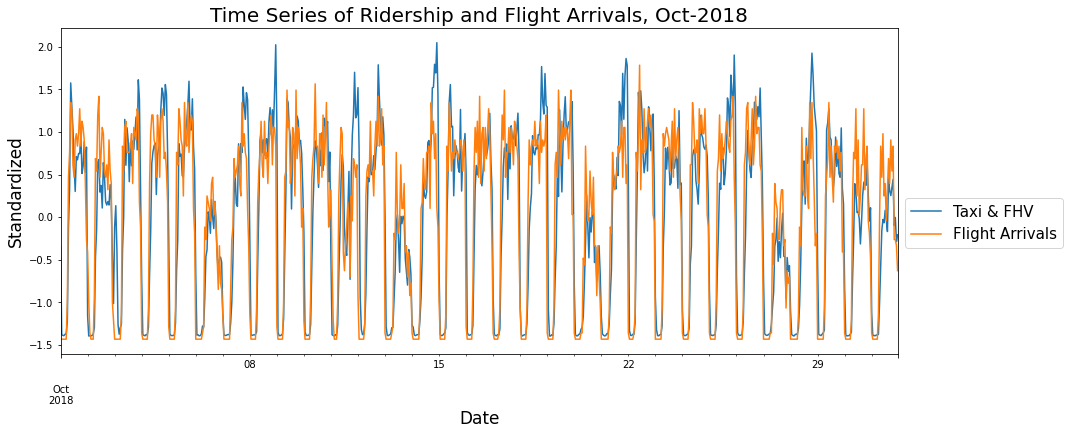

In [27]:
fig,ax = plt.subplots(figsize=(15,6))

hm_tr_fa.plot(x='Date', y='vehicle_count_st', ax=ax, label='Taxi & FHV')
hm_tr_fa.plot(x='Date', y='arrivals_st', ax=ax, label='Flight Arrivals')
ax.legend(fontsize=15, loc='best', bbox_to_anchor=(1, 0.5))
ax.set_title('Time Series of Ridership and Flight Arrivals, Oct-2018', fontsize=20)
ax.set_xlabel('Date', fontsize=17)
ax.set_ylabel('Standardized', fontsize=17)

## Linear Regression Modeling of FHV and taxi ridership vs Arrivals data

In [28]:
tr_fa['Day'] = ((tr_fa.Date-dt.datetime(2018,1,1))/dt.timedelta(days = 1)).astype(int)
tr_fa['Hour']=pd.DatetimeIndex(tr_fa.Date).hour
tr_fa

,Date,vehicle_count,arrivals,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,DOW,Month,Day,Hour
0,2018-01-01 00:00:00,142.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
1,2018-01-01 01:00:00,23.0,0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1
2,2018-01-01 02:00:00,2.0,1,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,2
3,2018-01-01 03:00:00,1.0,0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,3
4,2018-01-01 04:00:00,13.0,0,0.0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-12-31 19:00:00,467.0,11,12.0,21.0,20.0,17.0,21.0,27.0,17.0,11.0,28.0,23.0,22.0,11.0,0,12,364,19
8756,2018-12-31 20:00:00,599.0,13,11.0,12.0,21.0,20.0,17.0,21.0,27.0,17.0,11.0,28.0,23.0,22.0,0,12,364,20
8757,2018-12-31 21:00:00,384.0,8,13.0,11.0,12.0,21.0,20.0,17.0,21.0,27.0,17.0,11.0,28.0,23.0,0,12,364,21
8758,2018-12-31 22:00:00,410.0,8,8.0,13.0,11.0,12.0,21.0,20.0,17.0,21.0,27.0,17.0,11.0,28.0,0,12,364,22


In [29]:
#first 90 days as train set
train_ = tr_fa.loc[(tr_fa['Day'] >= 0) & (tr_fa['Day'] <=89)]
#next 180 days as valid set
valid_ = tr_fa.loc[(tr_fa['Day'] >= 90) & (tr_fa['Day']  <=269)]
#last 90 days as test set
test_ = tr_fa.loc[(tr_fa['Day'] >= 275) & (tr_fa['Day']  <=364)]

#create copy to avoid chain assignment in later tasks
train = copy.deepcopy(train_)
valid = copy.deepcopy(valid_)
test = copy.deepcopy(test_)

In [30]:
#linear model with intercept
lm_q4_2 = smf.ols(formula='vehicle_count~arrivals', data=train).fit()
print(lm_q4_2.summary())

                            OLS Regression Results                            
Dep. Variable:          vehicle_count   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     5657.
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        17:01:47   Log-Likelihood:                -14690.
No. Observations:                2160   AIC:                         2.938e+04
Df Residuals:                    2158   BIC:                         2.939e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     75.8315      7.772      9.757      0.0

In [31]:
#print out just the P-values
lm_q4_2.pvalues

Intercept    4.869764e-22
arrivals     0.000000e+00
dtype: float64

From the summary table and code cell above, it seems that the P-value is near 0 for both the intercept and the regressor. This should tell us that the test is statistically significant.

In [32]:
#99% confidence interval
lm_q4_2.conf_int(alpha=0.01)

,0,1
Intercept,55.794760,95.868142
arrivals,25.382394,27.184322


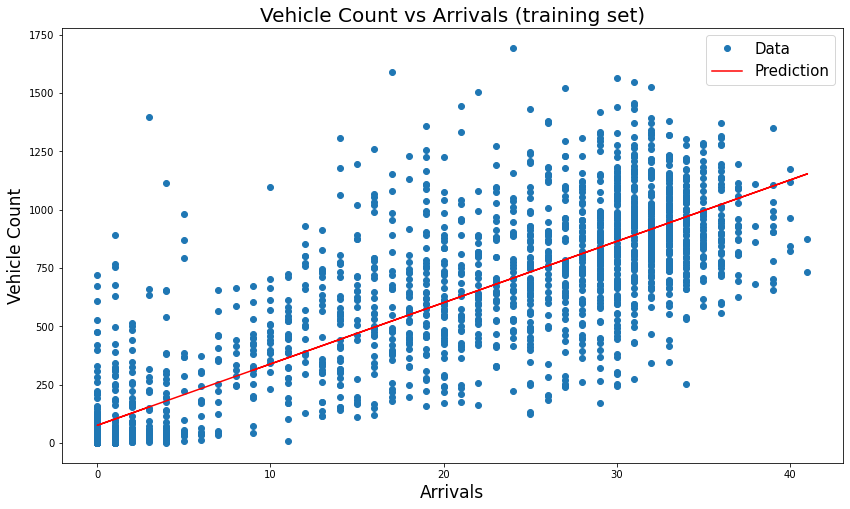

In [33]:
#scatter plot 
plt.figure(figsize=(14,8))
plt.plot(train['arrivals'], train['vehicle_count'], 'o', label='Data')
plt.title('Vehicle Count vs Arrivals (training set)', fontsize = 20)
plt.xlabel('Arrivals', fontsize=17)
plt.ylabel('Vehicle Count', fontsize=17)
plt.plot(train['arrivals'], lm_q4_2.predict(), '-r', label='Prediction')
plt.legend(fontsize=15, loc='best')

### Impact of immediate history of arrivals

In [34]:
#linear model on arrivals and all 12 lagged arrivals
lm_q4_3 = smf.ols(formula='vehicle_count ~arrivals+' + ' + '.join(train.columns[3:15]), data=train, missing='drop').fit()
print(lm_q4_3.summary())

                            OLS Regression Results                            
Dep. Variable:          vehicle_count   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     1001.
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        17:01:48   Log-Likelihood:                -13884.
No. Observations:                2148   AIC:                         2.780e+04
Df Residuals:                    2134   BIC:                         2.788e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -53.5959      9.574     -5.598      0.0

In [35]:
#just the P-values
lm_q4_3.pvalues

Intercept    2.444927e-08
arrivals     3.481606e-86
lag1         6.203229e-77
lag2         8.519404e-17
lag3         4.153651e-02
lag4         6.081657e-02
lag5         3.800369e-01
lag6         4.696850e-01
lag7         1.502653e-01
lag8         6.862717e-02
lag9         6.104691e-03
lag10        2.334960e-01
lag11        1.617830e-01
lag12        6.172421e-02
dtype: float64

Based on the summary table and the P-value table, with <0.05 as the P-value threshold, it seems that arrival (i.e. lag0 ), lag 1, 2, 3, and 9 have the highest impact.

### Incorporate Temporal Patterns 

In [36]:
train_q44 = copy.deepcopy(train)
train_q44 = pd.get_dummies(train_q44, columns=['Hour', 'DOW'])
train_q44

,Date,vehicle_count,arrivals,lag1,lag2,lag3,lag4,lag5,lag6,lag7,...,Hour_21,Hour_22,Hour_23,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6
0,2018-01-01 00:00:00,142.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
1,2018-01-01 01:00:00,23.0,0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
2,2018-01-01 02:00:00,2.0,1,0.0,3.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
3,2018-01-01 03:00:00,1.0,0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
4,2018-01-01 04:00:00,13.0,0,0.0,1.0,0.0,3.0,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,2018-03-31 19:00:00,278.0,11,16.0,20.0,27.0,20.0,20.0,18.0,23.0,...,0,0,0,0,0,0,0,0,1,0
2156,2018-03-31 20:00:00,280.0,11,11.0,16.0,20.0,27.0,20.0,20.0,18.0,...,0,0,0,0,0,0,0,0,1,0
2157,2018-03-31 21:00:00,420.0,16,11.0,11.0,16.0,20.0,27.0,20.0,20.0,...,1,0,0,0,0,0,0,0,1,0
2158,2018-03-31 22:00:00,279.0,14,16.0,11.0,11.0,16.0,20.0,27.0,20.0,...,0,1,0,0,0,0,0,0,1,0


In [37]:
lm_q4_4 = smf.ols(formula='vehicle_count ~arrivals+' + ' + '.join(train_q44.columns[3:15]) + '+' + ' + '.join(train_q44.columns[17:]) , data=train_q44, missing='drop').fit()
print(lm_q4_4.summary())

                            OLS Regression Results                            
Dep. Variable:          vehicle_count   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     448.5
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        17:01:48   Log-Likelihood:                -13522.
No. Observations:                2148   AIC:                         2.713e+04
Df Residuals:                    2105   BIC:                         2.737e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     46.7069      9.394      4.972      0.0

### Perform feature selection for lag variables

In [38]:
tick = ['lag0','lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12']
row = []

for a in range(0,13):    
    lm_q4_5_ = smf.ols(formula='vehicle_count~' + ' + '.join(train.columns[2:a+3]), data=train).fit()
    y_pred = lm_q4_5_.predict(valid.iloc[:, 2:a+3])
    row.append(r2_score(valid.vehicle_count,y_pred))
        
row  
q4_5_valid_r = pd.DataFrame(row, columns=['R^2 on Validation'], index=tick)
q4_5_valid_r  

,R^2 on Validation
lag0,0.679811
lag1,0.795688
lag2,0.809930
lag3,0.809493
lag4,0.809957
lag5,0.811447
lag6,0.813325
lag7,0.817830
lag8,0.821147
lag9,0.822537


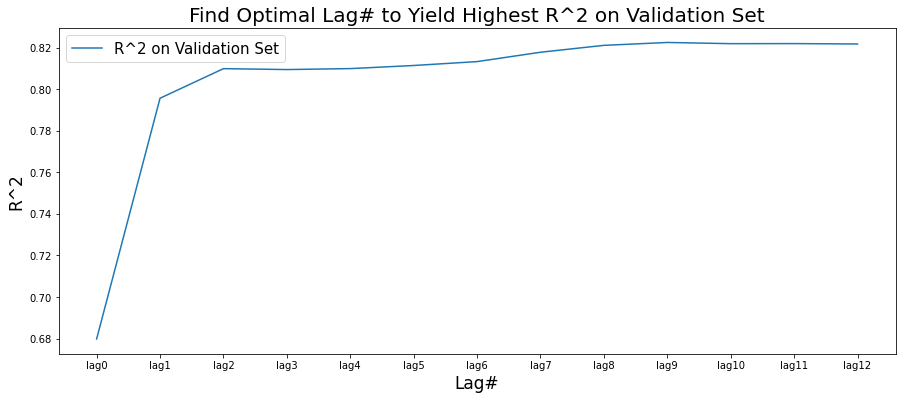

In [39]:
#plot the R^2 values
fig,ax = plt.subplots(figsize=(15,6))

ax.plot(q4_5_valid_r['R^2 on Validation'], label='R^2 on Validation Set')
ax.set_xlabel('Lag#', fontsize=17)
ax.set_ylabel('R^2', fontsize=17)
ax.set_title('Find Optimal Lag# to Yield Highest R^2 on Validation Set', fontsize=20)
ax.legend(fontsize=15, loc='best')

Since R^2 doesn't increase as much after lag2, it seems that we'll add 2 lags for our regression formula.

In [40]:
#build linear model again using this most optimal lag#
lm_q4_5 = smf.ols(formula='vehicle_count~arrivals+lag1+lag2', data=train).fit()

#evaluate over test set
y_pred_ = lm_q4_5.predict(test[['arrivals', 'lag1', 'lag2']])
print("The R^2 on the test set obtained using the optimal lag# is : {0}".format(r2_score(test.vehicle_count,y_pred_)))

The R^2 on the test set obtained using the optimal lag# is : 0.7987188883767016


###  Visualize temporal patterns and lag impacts through bar plots

In [41]:
lm_q4_6 = smf.ols(formula='vehicle_count~arrivals+lag1+lag2+' + ' + '.join(train_q44.columns[17:]), data=train_q44).fit()
print(lm_q4_6.summary())

                            OLS Regression Results                            
Dep. Variable:          vehicle_count   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     590.9
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        17:01:49   Log-Likelihood:                -13591.
No. Observations:                2158   AIC:                         2.725e+04
Df Residuals:                    2125   BIC:                         2.743e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     60.7006      7.750      7.832      0.0

In [42]:
q4_6 = lm_q4_6.params.to_frame()
q4_6 = q4_6.rename(columns={0:'coef_'})
q4_6

,coef_
Intercept,60.700555
arrivals,10.285299
lag1,11.762533
lag2,4.491242
Hour_0,-10.049702
Hour_1,-128.550472
Hour_2,-81.224094
Hour_3,-68.592832
Hour_4,-63.343368
Hour_5,-61.025703


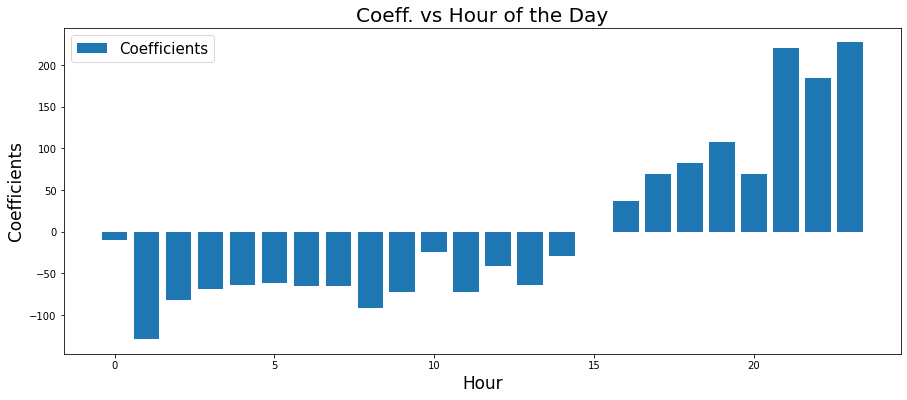

In [43]:
#hour of the day vs coefficients
fig,ax = plt.subplots(figsize=(15,6))

ax.bar(x=range(0,24), height=q4_6.iloc[4:28,:].to_numpy().reshape(24), label='Coefficients')
ax.set_xlabel('Hour', fontsize=17)
ax.set_ylabel('Coefficients', fontsize=17)
ax.set_title('Coeff. vs Hour of the Day', fontsize=20)
ax.legend(fontsize=15, loc='best')

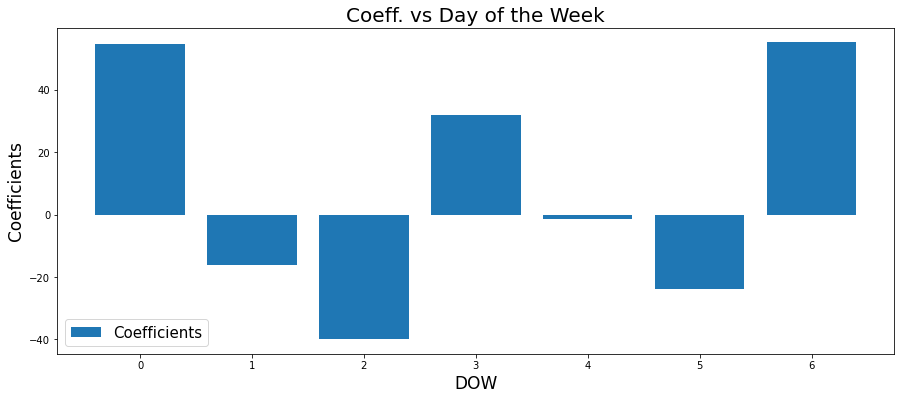

In [44]:
#day of the week vs coefficients
fig,ax = plt.subplots(figsize=(15,6))

ax.bar(x=range(0,7), height=q4_6.iloc[28:,:].to_numpy().reshape(7), label='Coefficients')
ax.set_xlabel('DOW', fontsize=17)
ax.set_ylabel('Coefficients', fontsize=17)
ax.set_title('Coeff. vs Day of the Week', fontsize=20)
ax.legend(fontsize=15, loc='best')

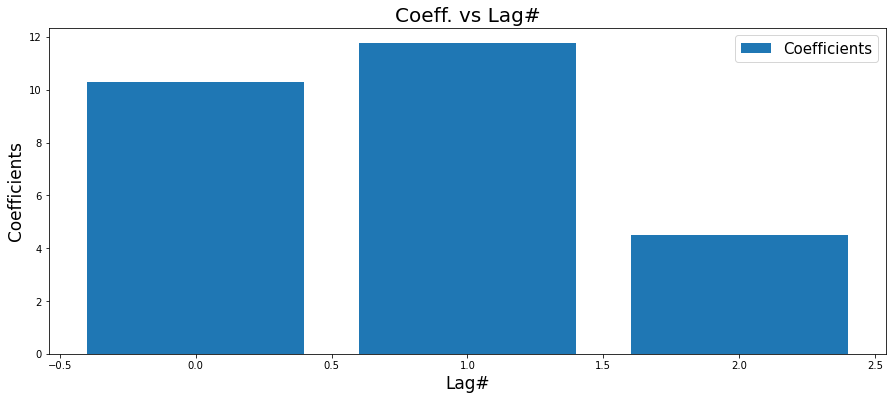

In [45]:
#day of the week vs coefficients
fig,ax = plt.subplots(figsize=(15,6))

ax.bar(x=range(0,3), height=q4_6.iloc[1:4,:].to_numpy().reshape(3), label='Coefficients')
ax.set_xlabel('Lag#', fontsize=17)
ax.set_ylabel('Coefficients', fontsize=17)
ax.set_title('Coeff. vs Lag#', fontsize=20)
ax.legend(fontsize=15, loc='best')

## Clustering of the days of the year based on the relative timeline of their taxi departures from the airport

In [46]:
tr_fa_5 = copy.deepcopy(tr_fa)
#day in the year as rows, hours as columns
task5 = pd.pivot_table(tr_fa_5, values='vehicle_count', index='Day', columns='Hour', aggfunc=np.sum)
task5

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Day,,,,,,,,,,,,,,,,,,,,,
0,142.0,23.0,2.0,1.0,13.0,13.0,15.0,46.0,248.0,443.0,...,765.0,865.0,776.0,1182.0,804.0,765.0,744.0,1025.0,1196.0,1079.0
1,791.0,50.0,28.0,2.0,5.0,16.0,24.0,301.0,550.0,1117.0,...,892.0,650.0,820.0,927.0,979.0,940.0,811.0,1048.0,1034.0,735.0
2,674.0,309.0,24.0,3.0,8.0,12.0,44.0,176.0,531.0,777.0,...,700.0,688.0,907.0,1011.0,871.0,713.0,507.0,480.0,566.0,301.0
3,295.0,11.0,2.0,1.0,10.0,15.0,43.0,31.0,32.0,29.0,...,68.0,80.0,40.0,45.0,29.0,28.0,21.0,32.0,37.0,72.0
4,387.0,164.0,29.0,15.0,7.0,14.0,36.0,92.0,89.0,232.0,...,591.0,679.0,723.0,883.0,882.0,950.0,894.0,1055.0,761.0,957.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,572.0,124.0,52.0,3.0,4.0,17.0,60.0,174.0,694.0,863.0,...,859.0,968.0,806.0,997.0,1108.0,1136.0,915.0,603.0,942.0,665.0
361,470.0,656.0,390.0,66.0,14.0,15.0,65.0,200.0,536.0,769.0,...,951.0,977.0,983.0,966.0,1075.0,1003.0,907.0,1167.0,1214.0,721.0
362,627.0,139.0,4.0,6.0,5.0,30.0,64.0,122.0,464.0,603.0,...,664.0,975.0,844.0,877.0,1026.0,954.0,1082.0,1048.0,710.0,765.0


In [47]:
#normalize by total daily ridership
task5_norm = copy.deepcopy(task5)
task5_norm = task5_norm.div(task5_norm.sum(axis=1), axis=0)
task5_norm

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Day,,,,,,,,,,,,,,,,,,,,,
0,0.011312,0.001832,0.000159,0.000080,0.001036,0.001036,0.001195,0.003664,0.019756,0.035290,...,0.060942,0.068908,0.061818,0.094161,0.064048,0.060942,0.059269,0.081654,0.095276,0.085956
1,0.053023,0.003352,0.001877,0.000134,0.000335,0.001073,0.001609,0.020177,0.036868,0.074876,...,0.059794,0.043572,0.054967,0.062140,0.065625,0.063011,0.054364,0.070251,0.069312,0.049269
2,0.055675,0.025525,0.001982,0.000248,0.000661,0.000991,0.003635,0.014538,0.043863,0.064183,...,0.057823,0.056831,0.074922,0.083512,0.071948,0.058896,0.041880,0.039650,0.046754,0.024864
3,0.248316,0.009259,0.001684,0.000842,0.008418,0.012626,0.036195,0.026094,0.026936,0.024411,...,0.057239,0.067340,0.033670,0.037879,0.024411,0.023569,0.017677,0.026936,0.031145,0.060606
4,0.033489,0.014192,0.002510,0.001298,0.000606,0.001211,0.003115,0.007961,0.007702,0.020076,...,0.051142,0.058757,0.062565,0.076411,0.076324,0.082208,0.077362,0.091295,0.065853,0.082814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.038981,0.008450,0.003544,0.000204,0.000273,0.001159,0.004089,0.011858,0.047295,0.058812,...,0.058539,0.065967,0.054927,0.067943,0.075508,0.077416,0.062355,0.041093,0.064195,0.045318
361,0.028664,0.040007,0.023785,0.004025,0.000854,0.000915,0.003964,0.012197,0.032689,0.046899,...,0.057998,0.059584,0.059950,0.058913,0.065561,0.061170,0.055315,0.071172,0.074038,0.043971
362,0.045037,0.009984,0.000287,0.000431,0.000359,0.002155,0.004597,0.008763,0.033329,0.043313,...,0.047694,0.070033,0.060623,0.062994,0.073696,0.068525,0.077719,0.075277,0.050998,0.054949


### Silhouette score Computing

In [48]:
range_n_clusters = range(2, 8)
row = []
for n_clusters in range_n_clusters: 
    km = KMeans(n_clusters=n_clusters)
    cluster_labels = km.fit_predict(task5_norm)
    #set a random_state value so that the results don't vary (much?) each time i run the code
    silhouette_avg = silhouette_score(task5_norm, cluster_labels, random_state=324)
    row.append(silhouette_avg)
row
q6_2_sil = pd.DataFrame(row, index=range(2,8), columns=['score'])
q6_2_sil

,score
2,0.189298
3,0.223241
4,0.233295
5,0.221286
6,0.176512
7,0.167294


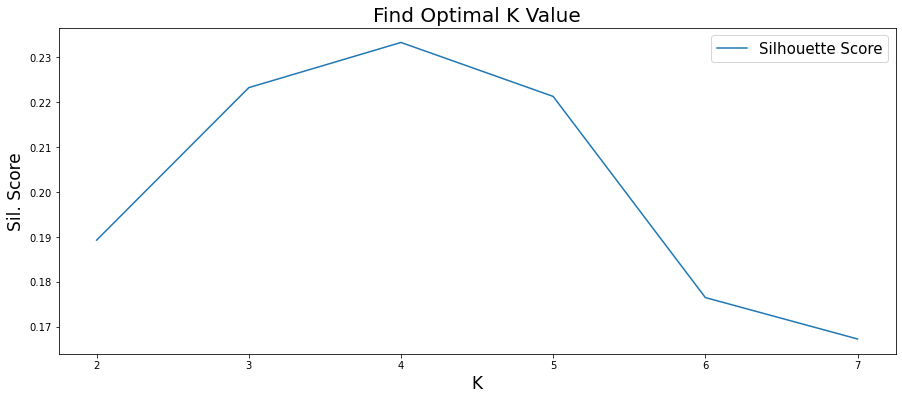

In [49]:
#plot the R^2 values
fig,ax = plt.subplots(figsize=(15,6))

ax.plot(q6_2_sil['score'], label='Silhouette Score')
ax.set_xlabel('K', fontsize=17)
ax.set_ylabel('Sil. Score', fontsize=17)
ax.set_title('Find Optimal K Value', fontsize=20)
ax.legend(fontsize=15, loc='best')

It seems that k=4 is the most optimal choice.

### Perform K-means with the optimal k

In [50]:
# number of clusters
n=4 

#train the model
kmq6_3=KMeans(n_clusters=n, random_state=324)
reskq6_3=kmq6_3.fit(task5_norm)
reskq6_3.labels_ = reskq6_3.predict(task5_norm)
#dictionary code from hw 8
clust={task5_norm.index[i]:reskq6_3.labels_[i] for i in range(len(reskq6_3.labels_))}
task5_norm['cluster'] = task5_norm.index.map(clust)
task5_norm

Hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,cluster
Day,,,,,,,,,,,,,,,,,,,,,
0,0.011312,0.001832,0.000159,0.000080,0.001036,0.001036,0.001195,0.003664,0.019756,0.035290,...,0.068908,0.061818,0.094161,0.064048,0.060942,0.059269,0.081654,0.095276,0.085956,0
1,0.053023,0.003352,0.001877,0.000134,0.000335,0.001073,0.001609,0.020177,0.036868,0.074876,...,0.043572,0.054967,0.062140,0.065625,0.063011,0.054364,0.070251,0.069312,0.049269,1
2,0.055675,0.025525,0.001982,0.000248,0.000661,0.000991,0.003635,0.014538,0.043863,0.064183,...,0.056831,0.074922,0.083512,0.071948,0.058896,0.041880,0.039650,0.046754,0.024864,3
3,0.248316,0.009259,0.001684,0.000842,0.008418,0.012626,0.036195,0.026094,0.026936,0.024411,...,0.067340,0.033670,0.037879,0.024411,0.023569,0.017677,0.026936,0.031145,0.060606,2
4,0.033489,0.014192,0.002510,0.001298,0.000606,0.001211,0.003115,0.007961,0.007702,0.020076,...,0.058757,0.062565,0.076411,0.076324,0.082208,0.077362,0.091295,0.065853,0.082814,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.038981,0.008450,0.003544,0.000204,0.000273,0.001159,0.004089,0.011858,0.047295,0.058812,...,0.065967,0.054927,0.067943,0.075508,0.077416,0.062355,0.041093,0.064195,0.045318,1
361,0.028664,0.040007,0.023785,0.004025,0.000854,0.000915,0.003964,0.012197,0.032689,0.046899,...,0.059584,0.059950,0.058913,0.065561,0.061170,0.055315,0.071172,0.074038,0.043971,1
362,0.045037,0.009984,0.000287,0.000431,0.000359,0.002155,0.004597,0.008763,0.033329,0.043313,...,0.070033,0.060623,0.062994,0.073696,0.068525,0.077719,0.075277,0.050998,0.054949,1


In [51]:
tr_fa_5

,Date,vehicle_count,arrivals,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,DOW,Month,Day,Hour
0,2018-01-01 00:00:00,142.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
1,2018-01-01 01:00:00,23.0,0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1
2,2018-01-01 02:00:00,2.0,1,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,2
3,2018-01-01 03:00:00,1.0,0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,3
4,2018-01-01 04:00:00,13.0,0,0.0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-12-31 19:00:00,467.0,11,12.0,21.0,20.0,17.0,21.0,27.0,17.0,11.0,28.0,23.0,22.0,11.0,0,12,364,19
8756,2018-12-31 20:00:00,599.0,13,11.0,12.0,21.0,20.0,17.0,21.0,27.0,17.0,11.0,28.0,23.0,22.0,0,12,364,20
8757,2018-12-31 21:00:00,384.0,8,13.0,11.0,12.0,21.0,20.0,17.0,21.0,27.0,17.0,11.0,28.0,23.0,0,12,364,21
8758,2018-12-31 22:00:00,410.0,8,8.0,13.0,11.0,12.0,21.0,20.0,17.0,21.0,27.0,17.0,11.0,28.0,0,12,364,22


In [52]:
task5_3 = tr_fa_5.merge(task5_norm[['cluster']], left_on='Day', right_index=True)
dow_cluster = pd.pivot_table(task5_3, values='Day', index='DOW', columns='cluster', aggfunc='count')
#recorded by hour, so divide by 24 for the day's total
dow_cluster = ((dow_cluster//24).replace(np.nan, 0))
dow_cluster

cluster,0,1,2,3
DOW,,,,
0,6.0,37.0,7.0,3.0
1,4.0,42.0,6.0,0.0
2,4.0,41.0,5.0,2.0
3,15.0,30.0,6.0,1.0
4,6.0,33.0,11.0,2.0
5,1.0,2.0,9.0,40.0
6,49.0,3.0,0.0,0.0


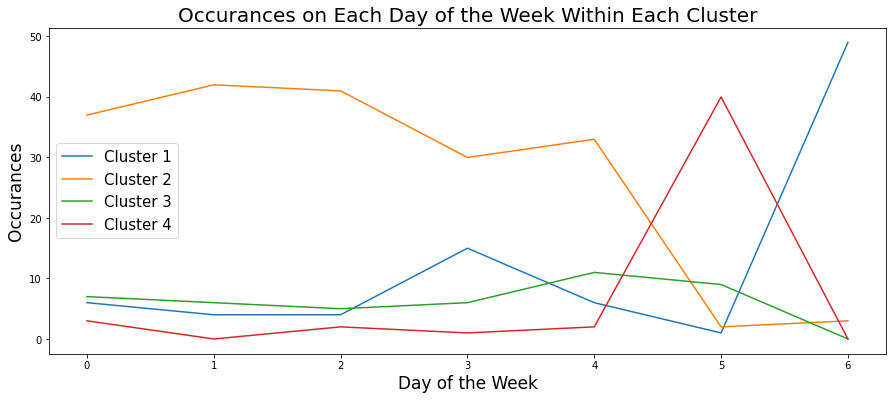

In [53]:
#Visualize occurances on each day of the week within each cluster
fig,ax = plt.subplots(figsize=(15,6))

ax.plot(dow_cluster.iloc[:,0], label='Cluster 1')
ax.plot(dow_cluster.iloc[:,1], label='Cluster 2')
ax.plot(dow_cluster.iloc[:,2], label='Cluster 3')
ax.plot(dow_cluster.iloc[:,3], label='Cluster 4')

ax.set_xlabel('Day of the Week', fontsize=17)
ax.set_ylabel('Occurances', fontsize=17)
ax.set_title('Occurances on Each Day of the Week Within Each Cluster', fontsize=20)
ax.legend(fontsize=15, loc='best')

In [54]:
dow_c = copy.deepcopy(dow_cluster)
dow_c['DOW Sum'] = dow_c.sum(axis=1)
dow_c.loc['Cluster Sum',:]= dow_c.sum(axis=0)
dow_c

cluster,0,1,2,3,DOW Sum
DOW,,,,,
0,6.0,37.0,7.0,3.0,53.0
1,4.0,42.0,6.0,0.0,52.0
2,4.0,41.0,5.0,2.0,52.0
3,15.0,30.0,6.0,1.0,52.0
4,6.0,33.0,11.0,2.0,52.0
5,1.0,2.0,9.0,40.0,52.0
6,49.0,3.0,0.0,0.0,52.0
Cluster Sum,85.0,188.0,44.0,48.0,365.0


It seems that sum of occurances accross all clusters is approximately the same. In addition, cluster 1 has the most number of occurances, and as it gets closer the weekened, the number of occurances in all clusters except for the third one varies more.

In [55]:
#check how many entry there is for cluster
from collections import Counter
cluster_check = task5_norm['cluster']
Counter(cluster_check)

Counter({0: 85, 1: 188, 3: 48, 2: 44})

In [56]:
#total riders per hour of the day within each cluster
hourly_ride_cluster = pd.pivot_table(task5_3, values='vehicle_count', index='Hour', columns='cluster', aggfunc=np.sum)
#no need to divide by 24 here since we're looking at hourly ridership throughout the year
hourly_ride_cluster

cluster,0,1,2,3
Hour,,,,
0,18248.0,83878.0,47450.0,20379.0
1,2334.0,9883.0,21391.0,2825.0
2,555.0,2883.0,4919.0,996.0
3,419.0,806.0,806.0,248.0
4,542.0,1149.0,535.0,362.0
5,827.0,1917.0,708.0,507.0
6,1754.0,7568.0,2165.0,1424.0
7,10413.0,71443.0,12578.0,3714.0
8,26954.0,125195.0,23807.0,13210.0


The normalization step is in the next question.

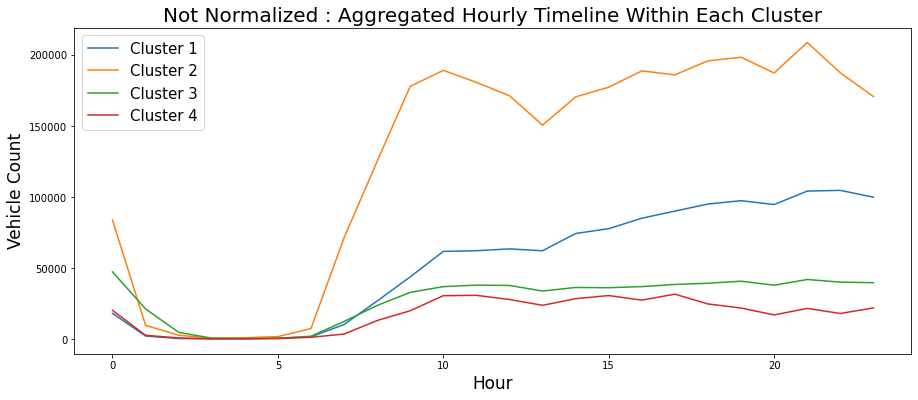

In [57]:
#Visualize the aggregated hourly timeline over all the days within each cluster
fig,ax = plt.subplots(figsize=(15,6))

ax.plot(hourly_ride_cluster.iloc[:,0], label='Cluster 1')
ax.plot(hourly_ride_cluster.iloc[:,1], label='Cluster 2')
ax.plot(hourly_ride_cluster.iloc[:,2], label='Cluster 3')
ax.plot(hourly_ride_cluster.iloc[:,3], label='Cluster 4')
ax.set_xlabel('Hour', fontsize=17)
ax.set_ylabel('Vehicle Count', fontsize=17)
ax.set_title('Not Normalized : Aggregated Hourly Timeline Within Each Cluster', fontsize=20)
ax.legend(fontsize=15, loc='best')

### Visualization of the hourly timeline for each cluster, and normalize by total riderships in the cluster.

In [58]:
#normalize by total cluster ridership
hourly_ride_cluster_norm = copy.deepcopy(hourly_ride_cluster)
hourly_ride_cluster_norm = hourly_ride_cluster_norm.div(hourly_ride_cluster_norm.sum(axis=0), axis=1)
hourly_ride_cluster_norm

cluster,0,1,2,3
Hour,,,,
0,0.014257,0.027542,0.069435,0.048279
1,0.001824,0.003245,0.031302,0.006693
2,0.000434,0.000947,0.007198,0.002360
3,0.000327,0.000265,0.001179,0.000588
4,0.000423,0.000377,0.000783,0.000858
5,0.000646,0.000629,0.001036,0.001201
6,0.001370,0.002485,0.003168,0.003374
7,0.008135,0.023459,0.018406,0.008799
8,0.021059,0.041108,0.034838,0.031295


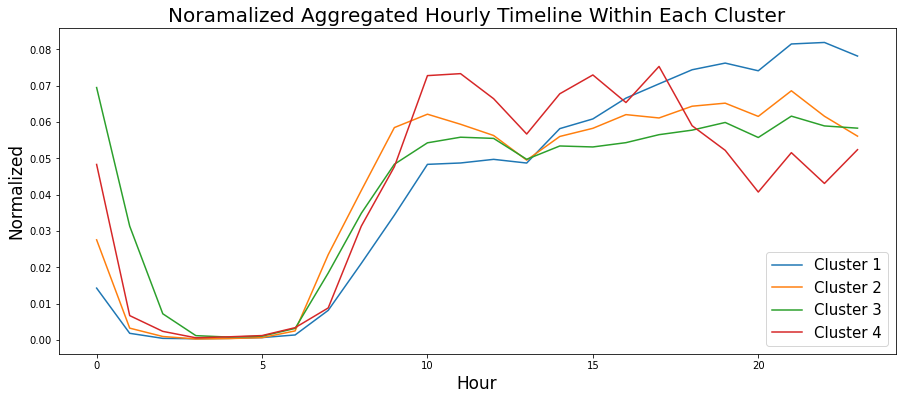

In [59]:
#Visualize the cluster-normalized aggregated hourly timeline over all the days within each cluster
fig,ax = plt.subplots(figsize=(15,6))

ax.plot(hourly_ride_cluster_norm.iloc[:,0], label='Cluster 1')
ax.plot(hourly_ride_cluster_norm.iloc[:,1], label='Cluster 2')
ax.plot(hourly_ride_cluster_norm.iloc[:,2], label='Cluster 3')
ax.plot(hourly_ride_cluster_norm.iloc[:,3], label='Cluster 4')
ax.set_xlabel('Hour', fontsize=17)
ax.set_ylabel('Normalized', fontsize=17)
ax.set_title('Noramalized Aggregated Hourly Timeline Within Each Cluster', fontsize=20)
ax.legend(fontsize=15, loc='best')